# Example 1
In the example of `README.md`, we use the information flow to query the causal relationship between two time series. Further, we can also use this method to query the causal relationship between multiple time series.

### Data 
We observed six time series by ODE linear system:
$\frac{dX}{dt} = AX +\alpha+ \epsilon$, if $A_{ij} \neq 0$.The of matrix A is (6,6),Aij indicates the influence from j to i.
$$A=\begin{bmatrix}
0&0&-0.6&0&0&0\\
-0.5&0&0&0&0&0.8\\
0&0.7&0&0&0&0\\
0&0&0&0.7&0.4&0\\
0&0&0&0.2&0&0.7\\
0&0&0&0&0&-0.5\\
\end{bmatrix}$$


We firstly create a directed graph to more intuitively express the causal influences between the time series reflected by the ODE system.

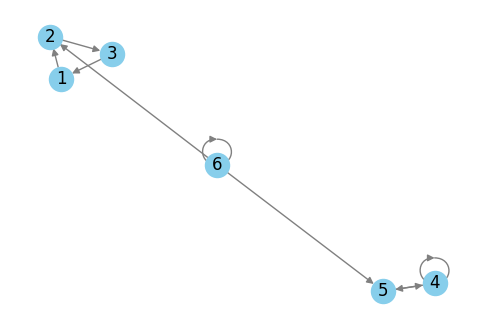

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6])
G.add_edges_from([(1, 2), (2, 3),(3,1) ,(4, 4), (4, 5),(5,4),(6,2),(6,5),(6,6)])

fig, ax = plt.subplots(figsize=(6, 4)) 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', arrows=True, ax=ax)


# 显示图形
plt.show()


We set $dt=0.1$ , the initial value of X is X[0], and the time series can be represented recursively as
$$ X[i+1]= AX[i]*dt+X[i]+\alpha*dt+\epsilon$$

(100, 6)


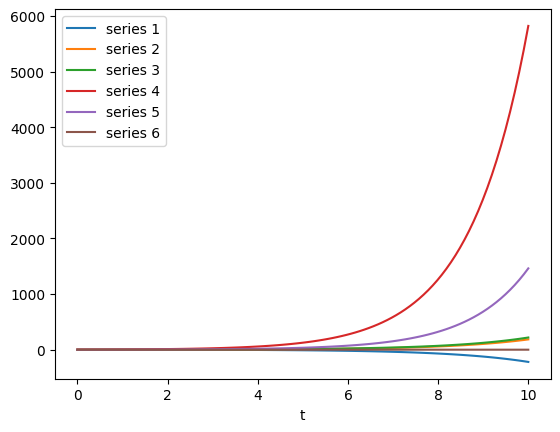

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt


alpha = np.array([0.1,0.7,0.5,0.2,0.8,0.3]).T
A = np.array([[0,0,-0.6,0,0,0],
             [-0.5,0,0,0,0,0.8],
             [0,0.7,0,0,0,0],
             [0,0,0,0.7,0.4,0],
             [0,0,0,0.2,0,0.7],
             [0,0,0,0,0,-0.5]]) # Aij indicates the influence from j to i

mu=0;sigma=1
B = np.zeros_like(A)
for i in range(6):
    B[i,i]=1

t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)
dt=0.1
x = np.empty((t_eval.shape[0],6)) 
x[0] = np.random.normal(mu,sigma,6) #initialization

#generate time series
for i in range(1,t_eval.shape[0]):
    x[i] = A@x[i-1]*dt+x[i-1]+alpha*dt+0.01*np.random.multivariate_normal(np.array([0,0,0,0,0,0]),B)
    
print(x.shape)

#plot
plt.figure()

plt.plot(t_eval, x[:,0], label='series 1')
plt.plot(t_eval, x[:,1], label='series 2')
plt.plot(t_eval, x[:,2], label='series 3')
plt.plot(t_eval, x[:,3], label='series 4')
plt.plot(t_eval, x[:,4], label='series 5')
plt.plot(t_eval, x[:,5], label='series 6')

plt.xlabel('t')
plt.legend()

The data is collected in variable x(a 100×2 data matrix observed with time step $\Delta t=0.1$).\
We now want to query the causal relationship among the six time series.\
If your data is a numpy array,please run the code below.
But it should be noted that in this example, the shape of x is (100,6),that is (T,C), while the shape of the function(`causal_est_matrix`) input is (C,T).

In [15]:
from causality_estimation import causal_est_matrix
cau, var, cau_normalized = causal_est_matrix(x.T, n_step=1, dt=0.1)

Then,we can obtain
* causality matrix `cau` whose $ij$'s entry indicates causality from $i$ to $j$ (the value can be positive and negative, positive values can be interpreted as "encouragement" effect while negative values can be interpreted as "surpression" effect),   
* variance matrix for the estimation `var` whose $ij$'s entry is the variance for estimated causality value of $ij$'s entry in `cau` ,
* normalized causality matrix `cau_normalized` whose $ij$'s entry indicates normalized causality from $i$ to $j$ .

A further statistical test as below,if
$$|cau_{ij}|>\sqrt{var_{ij}}*2.56$$
It means that there is about 98.96% $\approx$ 99% significant level for about 2.56 standard deviation away from 0,indicating that causality is statistically valid.\
Then run the code below to observed the causality matrix as a boolean type.If the matrix's $ij$ is 'True',it means that that causality from $i$ to $j$ is statistically valid.


In [16]:
print((np.abs(cau)>np.sqrt(var)*2.56))

[[False  True False False False  True]
 [False False  True False False False]
 [ True False False False False False]
 [False False False  True  True False]
 [False False False  True False False]
 [False False False False False  True]]


Next, we observe the indices of the 'True' elements in this Boolean matrix,they are \
($1\rightarrow 2$),($2\rightarrow 3$),($3\rightarrow 1$),($4\rightarrow 4$),($4\rightarrow 5$),($5\rightarrow 4$),($6\rightarrow 2$),($6\rightarrow 5$),($6\rightarrow 6$).\
The result is just right for the ODE system.

If you would like to use a torch implementation, you can use function `causal_est_matrix` from `Causality_est_torch.py` as 

In [17]:
from Causality_est_torch import causal_est_matrix
xx = torch.tensor(x.T, dtype=torch.float64)
causality1,variance1,normalized_causality1 = causal_est_matrix(xx,n_step=1,dt=dt)
print((np.abs(causality1)>np.sqrt(variance1)*2.56))

tensor([[False,  True, False, False, False,  True],
        [False, False,  True, False, False, False],
        [ True, False, False, False, False, False],
        [False, False, False,  True,  True, False],
        [False, False, False,  True, False, False],
        [False, False, False, False, False,  True]])


Besides,you can also get torch module `LiangCausalityEstimator` from the same file.

In [18]:
from Causality_est_torch import LiangCausalityEstimator
XX = torch.tensor(x.T, dtype=torch.float64)
model = LiangCausalityEstimator(n_step=1, dt=1)
XX = XX.unsqueeze(0)  # Add batch dimension
causality, variance, normalized_causality = model(XX)
print((np.abs(causality)>np.sqrt(variance)*2.56))

tensor([[[False,  True, False, False, False,  True],
         [False, False,  True, False, False, False],
         [ True, False, False, False, False, False],
         [False, False, False,  True,  True, False],
         [False, False, False,  True, False, False],
         [False, False, False, False, False,  True]]])


The above three results are completely consistent, but it should be noted that when converting to torch, make sure that there is a 64-bit float , otherwise there may be a discrepancies.

# Example 2
We've also provided a example_data here,and you can try it out using the above procedure by yourself.

In [19]:
xx=np.loadtxt('./example_data/case2_data.txt') # (100001, 6)
print(xx.shape)

(100001, 6)


In [ ]:
#numpy 
from causality_estimation import causal_est_matrix
cau, var, cau_normalized = causal_est_matrix(xx.T, n_step=1, dt=0.1)


#torch
from Causality_est_torch import causal_est_matrix
XX = torch.tensor(xx.T, dtype=torch.float64)
cau1,var1,cau_normalized1 = causal_est_matrix(XX,n_step=1,dt=1)


#module
from Causality_est_torch import LiangCausalityEstimator
X = torch.tensor(xx.T, dtype=torch.float64)
model = LiangCausalityEstimator(n_step=1, dt=1)
X = X.unsqueeze(0)  # Add batch dimension
cau2, var2, cau_normalized2 = model(X)




[[ True  True False False False False]
 [False  True  True False False False]
 [ True False  True False False False]
 [False False False  True  True False]
 [False False False  True  True False]
 [False  True False False  True  True]]
tensor([[ True,  True, False, False, False, False],
        [False,  True,  True, False, False, False],
        [ True, False,  True, False, False, False],
        [False, False, False,  True,  True, False],
        [False, False, False,  True,  True, False],
        [False,  True, False, False,  True,  True]])


tensor([[[ True,  True, False, False, False, False],
         [False,  True,  True, False, False, False],
         [ True, False,  True, False, False, False],
         [False, False, False,  True,  True, False],
         [False, False, False,  True,  True, False],
         [False,  True, False, False,  True,  True]]])
